In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchsummary import summary
import glob
import os
import pandas as pd
from PIL import Image
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
BATCH_SIZE = 16
NUM_WORKERS = 4
EPOCHS = 1000

torch.Size([16, 3, 256, 256])


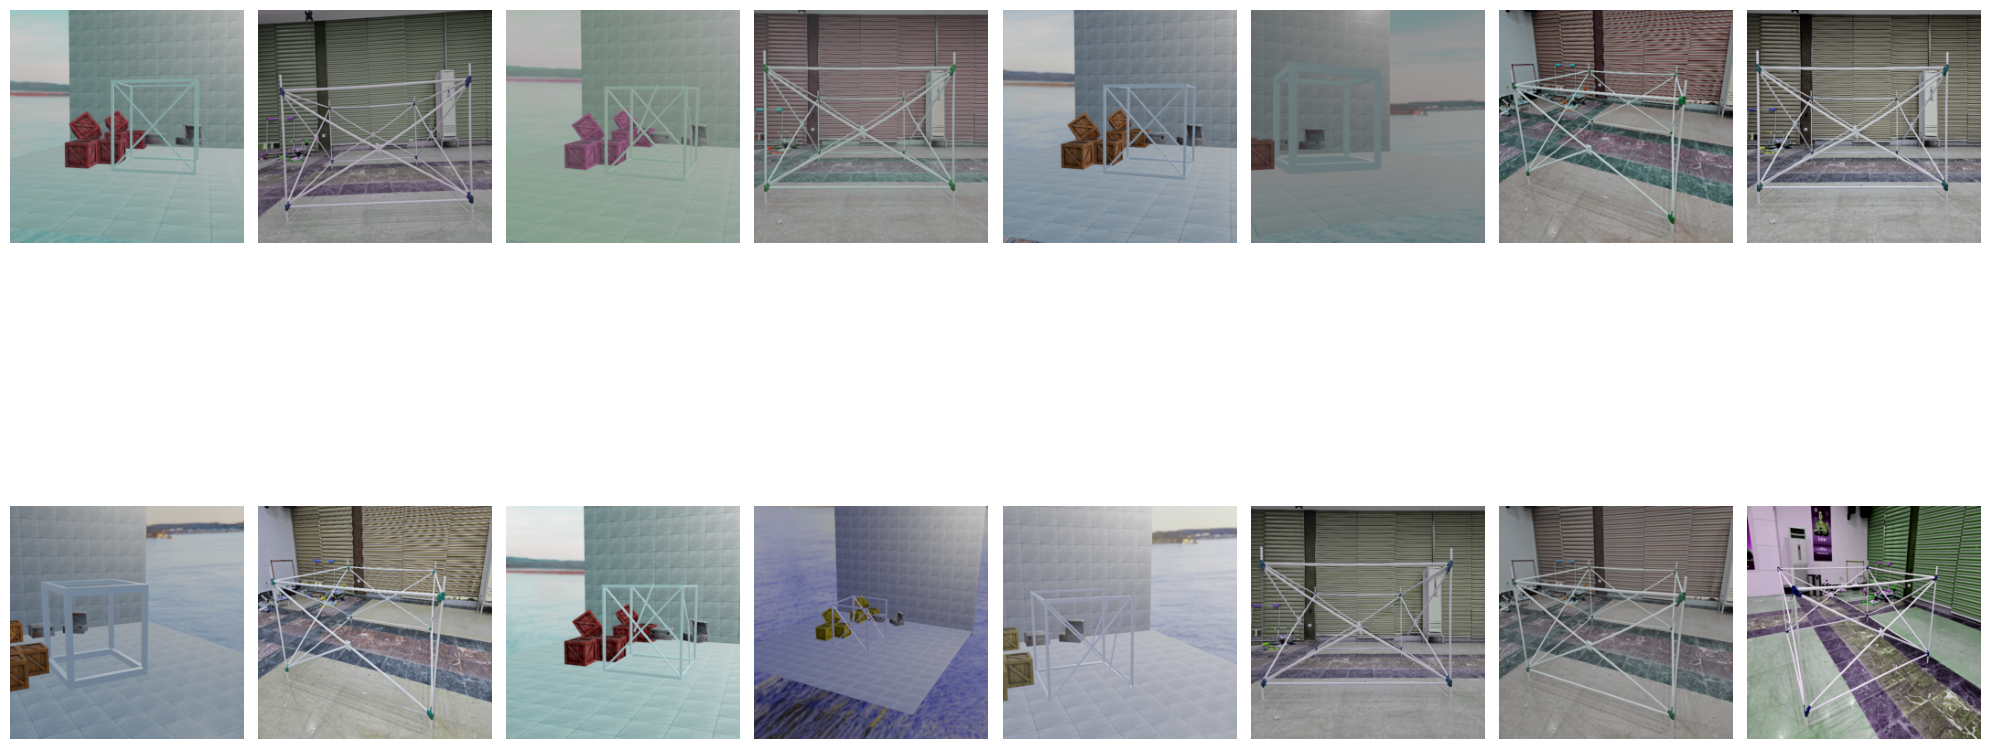

In [ ]:
class CubeDataset(Dataset):
    def __init__(self, models_dir="./data/models", real_dir="./data/real", models_csv="./data/annots/models.csv", real_csv="./data/annots/real.csv", transform=None):
        super().__init__()
        self.transform = transform

        # Read annotation CSVs
        models_df = pd.read_csv(models_csv, dtype=str).set_index("dir_name")
        real_df = pd.read_csv(real_csv, dtype=str).set_index("name")

        self.data = []  # list of (img_path, source_flag)
        self.labels = []  # list of 4x10 annotation lists
        self.source = []  # 0 for artificial, 1 for real
        # Process artificial (models) data
        for model_path in glob.glob(os.path.join(models_dir, "*")):
            dir_name = os.path.basename(model_path)
            if dir_name not in models_df.index:
                continue

            # all images in folder share the same annotation
            imgs = []
            for ext in ("*.jpeg", "*.jpg", "*.png"):
                imgs.extend(glob.glob(os.path.join(model_path, ext)))
            if not imgs:
                continue

            ann = models_df.loc[dir_name]
            face_labels = [[int(c) for c in ann[face].strip()] for face in ["front", "left", "back", "right"]]

            # add each image in the folder separately
            for img_path in imgs:
                self.data.append(img_path)
                self.labels.append(face_labels)
                self.source.append(0)

        # Process real data
        for ext in ("*.jpeg", "*.jpg", "*.png"):
            for img_path in glob.glob(os.path.join(real_dir, ext)):
                name = os.path.basename(img_path)
                if name not in real_df.index:
                    continue

                ann = real_df.loc[name]
                face_labels = [[int(c) for c in ann[face].strip()] for face in ["front", "left", "back", "right"]]

                self.data.append(img_path)
                self.labels.append(face_labels)
                self.source.append(1)

        assert len(self.data) == len(self.labels) == len(self.source), "Data, labels, and source length mismatch"

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.float32)  # [4,10]
        return img, label_tensor


train_transform = transforms.Compose(
    [
        # transforms.RandomResizedCrop(500),
        transforms.Resize((256, 256)),
        transforms.ColorJitter(0.2, 0.3, 0.3, 0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


train_dataset = CubeDataset(transform=train_transform)

source_counts = torch.bincount(torch.tensor(train_dataset.source, dtype=torch.long))
inv_counts = 1.0 / source_counts.float()
sample_weights = [inv_counts[s] for s in train_dataset.source]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)  # full epoch size  # allow oversampling of rare class

# DataLoader with Sampler
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

img = list(train_loader)[0][0]
print(img.shape)
plt.figure(figsize=(20, 20))
for i in range(len(img)):
    plt.subplot(4, 8, i + 1)
    img_show = img[i].permute(1, 2, 0)
    img_show = img_show * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img_show = torch.clamp(img_show, 0, 1)
    plt.imshow(img_show)
    plt.axis("off")
plt.tight_layout()

In [12]:
class MissingPipeNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # Feature extraction backbone
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            #
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            #
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            #
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            #
            nn.AdaptiveAvgPool2d(2),
        )

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 40),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x.view(-1, 4, 10)  # Reshape to [batch, 4, 10]


model = MissingPipeNetwork().to(device)
model(torch.randn((16, 3, 256, 256)))
summary(model, torch.randn((16, 3, 256, 256)))
print()

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 2, 2]            --
|    └─Conv2d: 2-1                       [-1, 32, 256, 256]        896
|    └─BatchNorm2d: 2-2                  [-1, 32, 256, 256]        64
|    └─ReLU: 2-3                         [-1, 32, 256, 256]        --
|    └─MaxPool2d: 2-4                    [-1, 32, 128, 128]        --
|    └─Conv2d: 2-5                       [-1, 64, 128, 128]        18,496
|    └─BatchNorm2d: 2-6                  [-1, 64, 128, 128]        128
|    └─ReLU: 2-7                         [-1, 64, 128, 128]        --
|    └─MaxPool2d: 2-8                    [-1, 64, 64, 64]          --
|    └─Conv2d: 2-9                       [-1, 64, 64, 64]          36,928
|    └─BatchNorm2d: 2-10                 [-1, 64, 64, 64]          128
|    └─ReLU: 2-11                        [-1, 64, 64, 64]          --
|    └─MaxPool2d: 2-12                   [-1, 64, 32, 32]          --
|   

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(1, EPOCHS + 1):
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)  # [B,4,10]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
        running_loss += loss.item() * imgs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch}/{EPOCHS} - Loss: {epoch_loss:.4f}")
    torch.save(model.state_dict(), './checkpoints/1.pth')

Epoch 1/1000 - Loss: 0.2921
Epoch 2/1000 - Loss: 0.1475
Epoch 3/1000 - Loss: 0.1375
Epoch 4/1000 - Loss: 0.1391
Epoch 5/1000 - Loss: 0.1345
Epoch 6/1000 - Loss: 0.1220
Epoch 7/1000 - Loss: 0.1124
Epoch 8/1000 - Loss: 0.1054
Epoch 9/1000 - Loss: 0.0934
Epoch 10/1000 - Loss: 0.0824
Epoch 11/1000 - Loss: 0.0840
Epoch 12/1000 - Loss: 0.0818
Epoch 13/1000 - Loss: 0.0748
Epoch 14/1000 - Loss: 0.0798
Epoch 15/1000 - Loss: 0.0671
Epoch 16/1000 - Loss: 0.0615
Epoch 17/1000 - Loss: 0.0567
Epoch 18/1000 - Loss: 0.0506
Epoch 19/1000 - Loss: 0.0522
Epoch 20/1000 - Loss: 0.0466
Epoch 21/1000 - Loss: 0.0411
Epoch 22/1000 - Loss: 0.0369
Epoch 23/1000 - Loss: 0.0368
Epoch 24/1000 - Loss: 0.0350


KeyboardInterrupt: 